# Helmholtz propagation

We can model the potential generated by the axicon by solving the Helmholtz equation numerically by applying the following transfer function:

<center>$H_{12} = \exp \left(-i kz_{12} \sqrt{1-\lambda^2\left(k_x^2+k_y^2\right)}\right)$

in the Fourier domain, so that if the initial E-field is $U_0(x,y)$ then

<center>$U(z) = \mathfrak{F}^{-1}\left\{H_{12}\cdot \mathfrak{F}\{U_0\}\right\}$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal 
%matplotlib inline

Define a class for the EM field:

In [ ]:
class Light():
    
    def __init__(self, N=1024, type='axicon'):
        ## Initial properties
        self.wavelength = 0.532 # all units in um
        self.resolution = N
        
        ## Optical parameters:
        axicon_number = 5
        vortex_number = 6
        spiralaxicon_number = 10
        
        # Frequency space
        freqx = np.linspace(-10,10,N)-1/N
        self.freqx, self.freqy = np.meshgrid(freqx, freqx)
        
        # Real space
        x = np.linspace(-10,10,N)
        self.X, self.Y = np.meshgrid(x,x)
        self.R = np.sqrt(np.power(self.X,2)+np.power(self.Y,2))
        self.theta = np.arctan(self.X/self.Y)
        
        # Initial field
        if type=='axicon':
            self.initial_field = np.exp(-0.5*np.power(self.R,2))*\
                np.exp(-axicon_number*1j*self.R)
                       
        elif type=='spiralaxicon':
            self.initial_field = np.exp(-0.5*np.power(self.R,2))*\
                np.exp(-spiralaxicon_number*1j*self.R + vortex_number*1j*self.theta)
        elif type=='pseudo-LG':
            self.initial_field = np.exp(-0.5*np.power(self.R,2))*\
                np.exp(vortex_number*1j*self.theta)
                
        self.Uz = self.initial_field
        self.Iz = np.abs(self.initial_field)
        
    def transfer_function(self, z):
        H = np.exp(1j*2*math.pi*(z/self.wavelength) * \
            np.sqrt(1-np.power((self.wavelength*self.freqx),2) - \
            np.power((self.wavelength*self.freqy),2)+0j))
        return H
        
    def propagate(self, z=10):
        
        ## Calculate the transfer function
        H = self.transfer_function(z)
        ## Propagate
        A0 = np.fft.fftshift(np.fft.fft2(self.initial_field))
        Az = A0*H
        self.Uz = np.fft.ifft2(np.fft.fftshift(Az))
        self.Iz = np.abs(self.Uz)
        
    def propagate_after_lens(self, z=10):
        
        ## Distance from axicon to lens
        z01 = 0.1;
        ## Focal length of lens
        f = 3;
        ## Distance from lens to z=0 image plane origin
        z23 = f+z
        
        ## Calculate the transfer functions
        H01 = self.transfer_function(f)
        H23 = self.transfer_function(z23)
        
        ## Go to fourier space
        A0 = np.fft.fftshift(np.fft.fft2(self.initial_field))
    
        ## Propagate to lens
        A1 = A0*H01       
        
        ## Get Lens operator
        Lens = np.fft.fftshift(np.fft.fft2(np.exp(-1j*(2*math.pi/self.wavelength)*np.power(self.R,2)/(2*f))))
        
        ## Apply lens
        A2 = signal.convolve2d(Lens, A1, boundary='symm', mode='same')
        
        ## Propagate from lens to output
#         A3 = A2*H23
            
        ## Go back to real space 
        self.Uz = np.fft.ifft2(np.fft.ifftshift(A1))
        self.Iz = np.abs(self.Uz)
        
    def show_intensity(self):
        fig, ax = plt.subplots(figsize=(5,5))
        cax = ax.imshow(self.Iz,cmap='gray')
        cbar = fig.colorbar(cax)
        plt.show()
    
    def show_phase(self):
        fig, ax = plt.subplots(figsize=(5,5))
        phase = np.angle(self.Uz)
        ax.imshow(phase, cmap='hsv')
        plt.show()
        
    def show_zplot(self, zlim=20, npoints=10):
        zprofile = []
        for z in np.linspace(0,zlim,npoints):
            self.propagate(z)
            cut = self.Iz[math.floor(self.resolution/2),:]
            zprofile.append(cut)
            
        return np.vstack(zprofile)

In [ ]:
light = Light(type='axicon',N=512)
light.propagate_after_lens(z=0)
light.show_intensity()

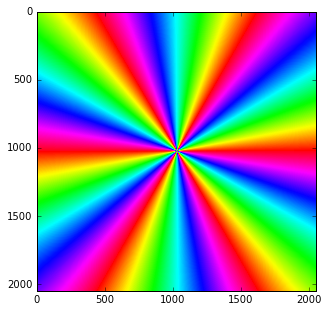

In [162]:
light = Light(type='pseudo-LG')
# light.propagate(z=90)
light.show_phase()

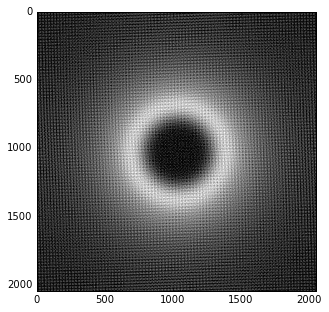

In [85]:
light = Light(type='pseudo-LG')
light.propagate(z=200)
light.show_intensity()

## Axicon propagation

Without a lens, the axicon should show a bessel beam in the near field. Let's plot the phase right after the axicon:

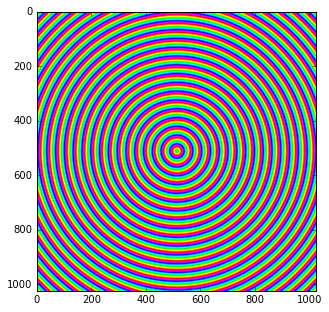

In [226]:
light = Light(type='axicon',N=1024)
light.show_phase()
zprofile = light.show_zplot(zlim=50, npoints = 20)

Plot the propagated z-profile as an image:

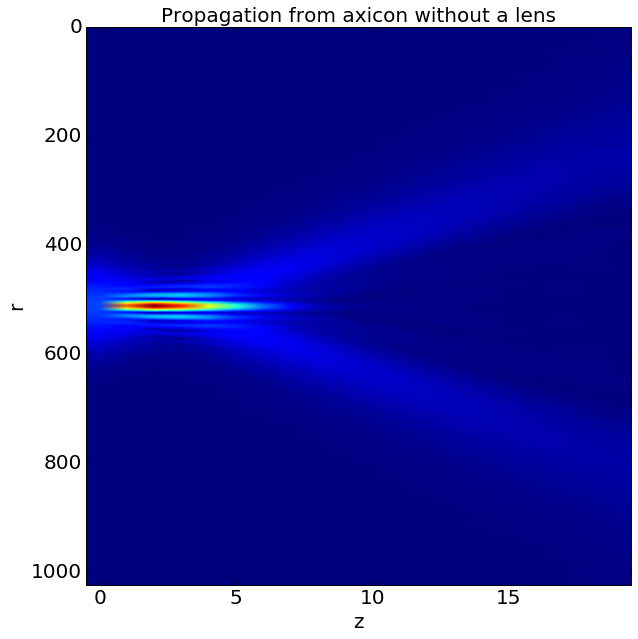

In [227]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(zprofile.transpose(), aspect=0.02)

plt.xlabel('z')
plt.ylabel('r')
plt.title('Propagation from axicon without a lens')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
plt.show()
fig.savefig('nolens.png')

With a lens, the image should show a ring at some point:

In [ ]:
light = Light(type='axicon',N=1024)
light.show_phase()
zprofile = light.show_zplot(zlim=50, npoints = 20)

1000.0